# Задача замены пропущенных данных в датасете

В датасете есть пропущенные значения. Наша задача предсказать их. Успешность предсказаний оценивается метрикой RMSE.

### Описание данных

В нашем распоряжении искусственно созданные производственные данные, содержащие пропущенные значения (из-за различного рода ошибок).

* **data.csv** - the file includes normalized continuous data and categorical data; your task is to predict the values of the missing data. файл, включающий нормализованные непрерывные и дискретные данные.
* **sample_submission.csv** - пример предоставляемого файла в требуемом формате

## Изучение данных

In [1]:
# Импортируем необходимые библиотеки.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.impute import SimpleImputer
from tqdm import tqdm
from lightgbm import LGBMRegressor
import time

In [2]:
# Прочитаем файлы.
data = pd.read_csv('data.csv', index_col=0)
sample_submission = pd.read_csv('sample_submission.csv', index_col=0)

In [3]:
# Посмотрим на датасет.
pd.set_option('display.max_columns', None)
display(data)

,F_1_0,F_1_1,F_1_2,F_1_3,F_1_4,F_1_5,F_1_6,F_1_7,F_1_8,F_1_9,F_1_10,F_1_11,F_1_12,F_1_13,F_1_14,F_2_0,F_2_1,F_2_2,F_2_3,F_2_4,F_2_5,F_2_6,F_2_7,F_2_8,F_2_9,F_2_10,F_2_11,F_2_12,F_2_13,F_2_14,F_2_15,F_2_16,F_2_17,F_2_18,F_2_19,F_2_20,F_2_21,F_2_22,F_2_23,F_2_24,F_3_0,F_3_1,F_3_2,F_3_3,F_3_4,F_3_5,F_3_6,F_3_7,F_3_8,F_3_9,F_3_10,F_3_11,F_3_12,F_3_13,F_3_14,F_3_15,F_3_16,F_3_17,F_3_18,F_3_19,F_3_20,F_3_21,F_3_22,F_3_23,F_3_24,F_4_0,F_4_1,F_4_2,F_4_3,F_4_4,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
row_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.354591,-0.464038,2.304115,0.734486,1.696395,0.136285,-0.518344,0.502640,-1.852504,-0.500665,-1.416075,1.201521,0.551902,-0.759827,NaN,2,2,0,3,2,1,1,3,2,2,3,3,2,5,4,1,0,1,0,2,1,2,0,1,2,-0.240522,0.061529,0.561090,-0.171943,-0.431996,0.473508,0.596924,0.819306,1.479061,1.264616,-1.116881,0.759443,-0.086915,-0.620685,0.057216,1.076380,-0.780608,-1.940907,-0.717021,0.599093,0.498347,0.118770,-0.228913,NaN,0.301610,5.547214,1.066871,-0.134313,-0.101040,-0.660871,3.744152,0.794438,0.265185,-0.561809,0.196480,0.373434,6.206995,3.809505,1.236486,1.182055
1,1.380940,-0.499626,-0.418548,1.911725,-0.826130,-1.715371,-0.577091,-1.041486,0.596067,-0.363425,-0.853630,0.674525,0.843058,-0.041438,0.259496,3,5,2,1,4,2,3,2,0,0,9,3,1,4,1,2,1,0,1,1,1,1,3,2,5,-0.446068,1.433358,0.040099,-1.994062,-0.602324,-0.611391,-1.151884,0.065485,0.352023,-0.843751,1.167272,0.921445,-0.839827,0.759015,-1.547387,0.720435,-0.944045,1.796462,-1.046357,-0.581515,0.704543,0.375222,0.705963,0.032771,NaN,-1.707374,-1.188114,-0.562419,-1.462988,1.290672,-2.895826,-0.738275,2.361818,-0.060753,0.727249,-0.271882,5.232157,-4.218259,-2.724883,-0.063775
2,0.256023,-1.059874,NaN,0.345678,1.513814,1.243864,-0.509648,-0.800481,-0.115945,0.595777,-0.073235,-1.381605,-0.108676,0.703693,-0.464042,3,2,1,3,2,1,0,6,1,1,3,4,1,2,2,1,2,2,4,8,1,5,1,2,4,-0.770592,0.483139,-0.636484,-1.305018,-2.089889,0.276761,-1.208640,-0.855769,0.232363,0.215841,-1.031405,0.582437,-0.314639,-0.497409,0.489356,0.915049,-0.513410,0.904206,-0.056089,0.212927,-0.574126,-1.517749,-0.888472,0.142264,1.000822,1.914908,3.877128,NaN,0.358635,0.443973,2.252834,0.472496,2.491386,0.353381,-0.260682,-0.000833,-0.116457,-2.131747,3.661499,-0.131576
3,-0.728420,-2.432399,-2.453602,-0.020509,0.333397,0.086049,-1.787601,0.667011,0.761564,-2.217847,-0.618973,0.742112,0.494157,0.744673,-0.769181,2,3,2,1,1,1,2,0,6,2,6,2,1,1,2,3,1,2,1,2,6,2,1,0,2,-0.691020,-1.003026,0.868989,0.464920,NaN,0.499838,0.203723,-0.451576,-1.233499,0.903493,1.144558,-1.479893,-0.414316,0.024820,-0.976814,0.176633,-0.940022,-1.918049,1.506448,0.604388,0.578250,-0.122676,-0.711811,0.228523,0.999599,-2.638262,0.546676,0.865400,-0.857077,2.667105,2.004600,-4.664806,-0.847211,-0.264249,0.664334,-0.557868,8.499483,-4.738799,-3.054611,0.494152
4,0.590212,-0.066127,0.468009,-1.096038,0.119399,-1.809710,0.466358,-0.053196,-0.580320,-1.143500,1.338692,1.193330,1.038010,-0.763692,0.513466,5,0,1,3,3,0,2,5,1,3,5,5,4,4,2,0,2,3,2,5,2,2,1,0,4,1.196402,1.076537,0.486482,0.424305,0.475876,0.426978,-1.668823,-0.843056,1.008980,-0.704152,-0.894834,1.491608,-0.149938,1.256330,2.427308,0.878677,0.594314,0.380175,0.666499,-0.664403,1.276316,NaN,-1.276574,-0.768874,1.852815,-0.230342,-0.459019,1.128705,-0.748683,NaN,0.976937,2.558883,3.377724,0.846891,0.696032,0.554121,-5.979714,-2.869631,3.733057,-0.722943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,-0.823740,0.285673,0.343307,-0.436747,1.700549,-1.069432,0.819698,-0.168457,-0.429074,0.844075,0.569298,0.235662,0.540328,-0.262106,-1.566722,4,8,1,4,4,0,1,1,2,1,2,1,0,4,1,1,1,1,2,2,3,0,3,0,6,0.030114,-0.698985,1.176185,-0.621560,-1.042985

In [4]:
# Изучим общую информацию.
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 80 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   F_1_0   981603 non-null   float64
 1   F_1_1   981784 non-null   float64
 2   F_1_2   981992 non-null   float64
 3   F_1_3   981750 non-null   float64
 4   F_1_4   981678 non-null   float64
 5   F_1_5   981911 non-null   float64
 6   F_1_6   981867 non-null   float64
 7   F_1_7   981872 non-null   float64
 8   F_1_8   981838 non-null   float64
 9   F_1_9   981751 non-null   float64
 10  F_1_10  982039 non-null   float64
 11  F_1_11  981830 non-null   float64
 12  F_1_12  981797 non-null   float64
 13  F_1_13  981602 non-null   float64
 14  F_1_14  981961 non-null   float64
 15  F_2_0   1000000 non-null  int64  
 16  F_2_1   1000000 non-null  int64  
 17  F_2_2   1000000 non-null  int64  
 18  F_2_3   1000000 non-null  int64  
 19  F_2_4   1000000 non-null  int64  
 20  F_2_5   1000000 non-null 

In [5]:
# Внимательнее посмотрим на данные.
data_desc = data.describe().T
data_desc.style.format(
    precision=0, 
    subset=(data_desc.index[0], data_desc.columns)
).background_gradient(cmap='GnBu',
    subset=(data_desc.index[1:], data_desc.columns)
)

,count,mean,std,min,25%,50%,75%,max
F_1_0,981603,-0,1,-5,-1,-0,1,5
F_1_1,981784.000000,0.002091,0.999878,-4.790594,-0.672284,0.002049,0.675997,5.042807
F_1_2,981992.000000,0.000551,0.999825,-4.870645,-0.673783,0.001386,0.674490,5.130025
F_1_3,981750.000000,0.000982,0.999847,-5.053023,-0.672211,0.000370,0.674852,5.462472
F_1_4,981678.000000,0.002437,1.001151,-5.363454,-0.672326,0.002733,0.676588,4.856916
F_1_5,981911.000000,0.000635,0.999927,-5.508223,-0.673884,0.000276,0.675951,4.960724
F_1_6,981867.000000,-0.000124,1.000427,-5.199170,-0.674834,0.000814,0.673983,4.957977
F_1_7,981872.000000,-0.063857,0.725986,-6.990302,-0.500305,0.000578,0.444337,2.527570
F_1_8,981838.000000,-0.000014,1.000715,-4.566593,-0.674006,-0.000047,0.674295,4.886075
F_1_9,981751.000000,0.000451,1.000194,-4.997549,-0.673513,0.001118,0.675575,4.788579


In [6]:
# Посчитаем количество пропусков и полных дубликатов в датасете.
print('Количество полных дубликатов в датасете:', data.duplicated().sum())
print('Количество пропущенных значений:', data.isna().sum().sum())

Количество полных дубликатов в датасете: 0
Количество пропущенных значений: 1000000


In [7]:
# Посчитаем количество пропущенных значений в каждой колонке.
pd.set_option('display.max_rows', None)
missed_vals_num = data.isna().sum()
missed_vals_num

F_1_0     18397
F_1_1     18216
F_1_2     18008
F_1_3     18250
F_1_4     18322
F_1_5     18089
F_1_6     18133
F_1_7     18128
F_1_8     18162
F_1_9     18249
F_1_10    17961
F_1_11    18170
F_1_12    18203
F_1_13    18398
F_1_14    18039
F_2_0         0
F_2_1         0
F_2_2         0
F_2_3         0
F_2_4         0
F_2_5         0
F_2_6         0
F_2_7         0
F_2_8         0
F_2_9         0
F_2_10        0
F_2_11        0
F_2_12        0
F_2_13        0
F_2_14        0
F_2_15        0
F_2_16        0
F_2_17        0
F_2_18        0
F_2_19        0
F_2_20        0
F_2_21        0
F_2_22        0
F_2_23        0
F_2_24        0
F_3_0     18029
F_3_1     18345
F_3_2     18056
F_3_3     18054
F_3_4     18373
F_3_5     18298
F_3_6     18192
F_3_7     18013
F_3_8     18098
F_3_9     18106
F_3_10    18200
F_3_11    18388
F_3_12    18297
F_3_13    18060
F_3_14    18139
F_3_15    18238
F_3_16    18122
F_3_17    18278
F_3_18    18089
F_3_19    18200
F_3_20    18248
F_3_21    18396
F_3_22  

In [8]:
total = data.shape[0] * data.shape[1]
missed = data.isna().sum().sum()
missed_percentage = missed / total
print(f'Пропущенные значения составляют {missed_percentage:.2%} от всего объема данных')

Пропущенные значения составляют 1.25% от всего объема данных


<AxesSubplot:>

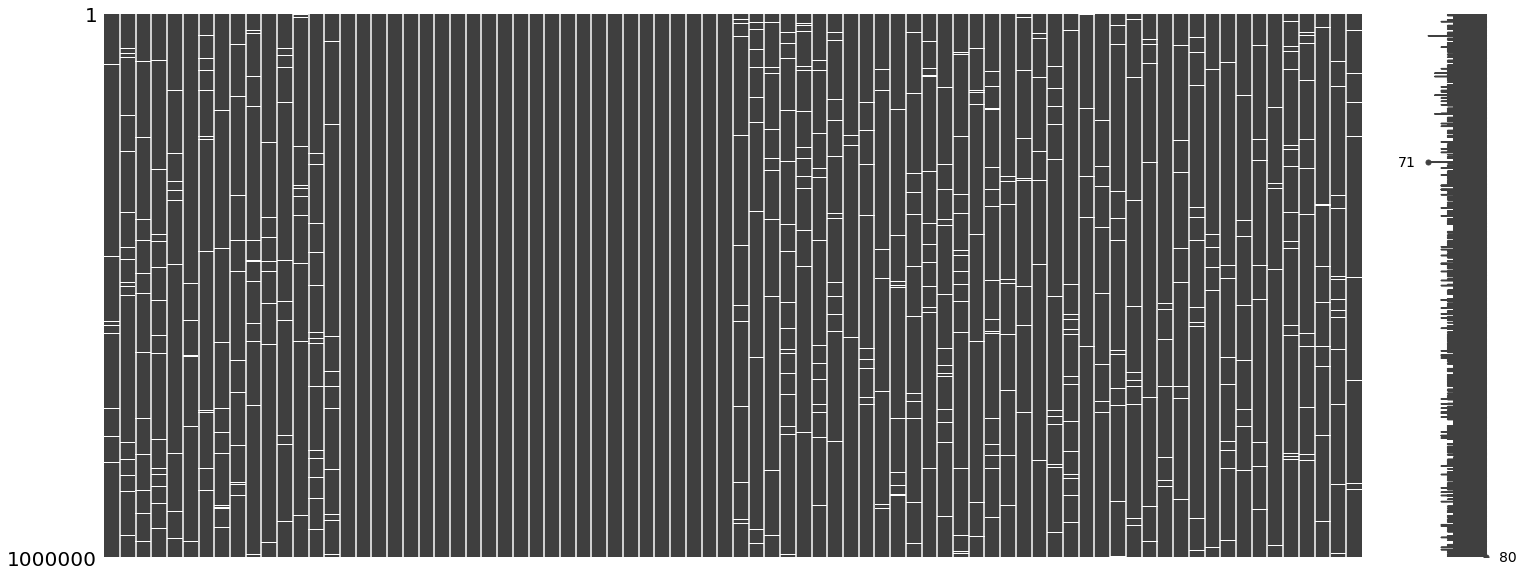

In [9]:
# Визуализируем пропуски.
msno.matrix(data)

### Вывод

Мы познакомились с данными и сейчас подведем первые итоги, которые позволят нам понять, в каком направлении двигаться дальше.
1. Датасет имеет размер 1_000_000 строк и 80 колонок. Всего 80 млн значений. Из них 1 млн — пропущенные значения, которые составляют 1,25 % от общего объема данных. Пропусков не так много, и от них можно было бы попросу избавиться, но наша задача состоит как раз в том, чтобы корректно заменить пропуски.  
2. Признаки можно разделить на 4 группы: F_1, F_2, F_3, F_4. Группы F_1, F_3 и F_4 содержат в себе вещественные числа, то есть это непрерывные величины. Группа F_2 содержит целые числа, то есть это дискретные величины.
3. Признаки группы F_2 не содержат пропусков. Значит мы можем изучить корреляцию других групп с группой F_2. Это нам поможет в замене пропусков.
4. На первый взгляд пропуски расположены случайно. Вероятно характер появления ошибок также был случайным.

## Изучение корреляции

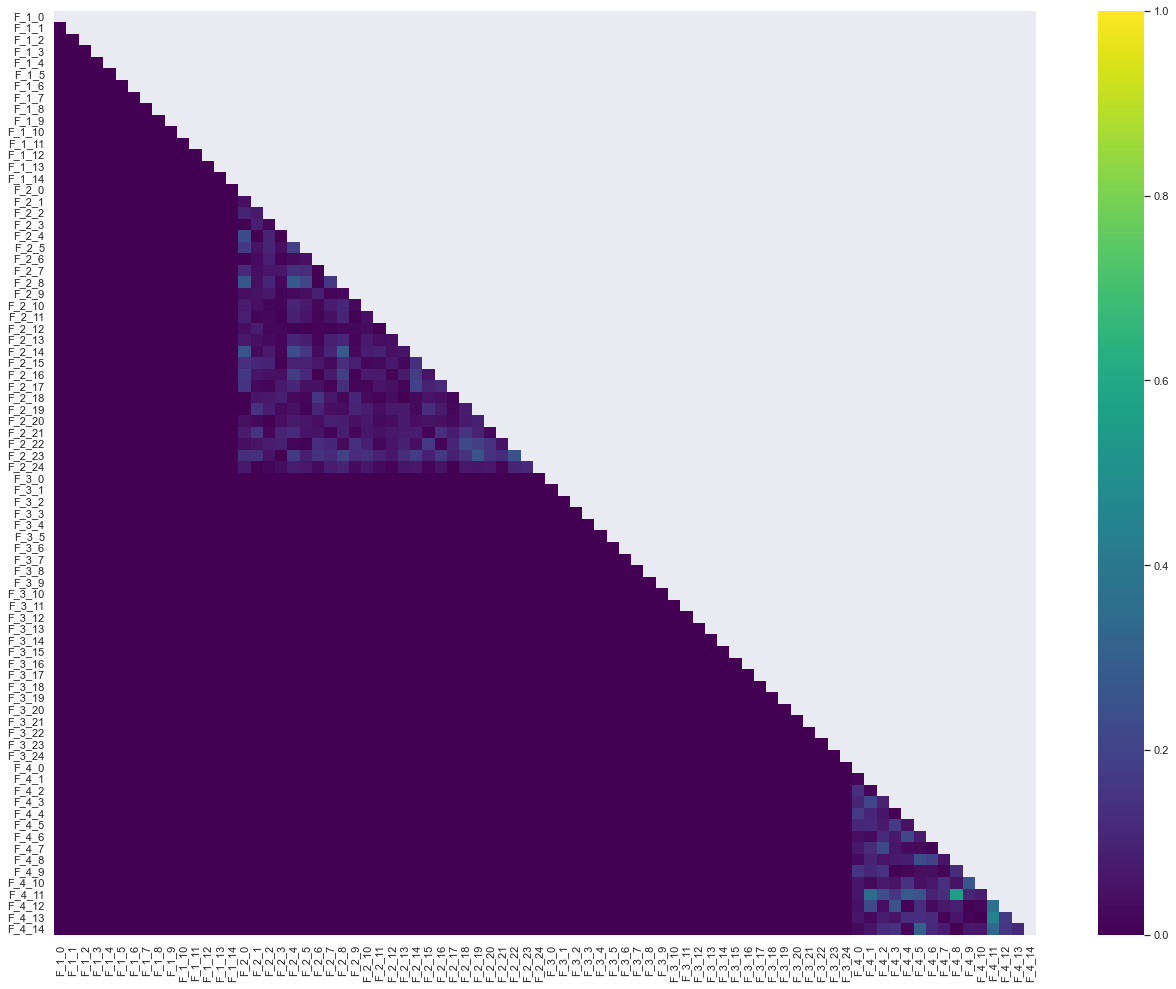

In [10]:
# Построим тепловую карту на основе матрицы корреляций.
corr = data.corr().abs()
sns.set(rc={'figure.figsize':(22,17)})
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, 
            mask=mask, 
            cmap='viridis', 
            vmin=0, 
            vmax=1)
plt.show()

### Вывод

* Признаки из группы F_4 коррелируют друг с другом. Это поможет нам в замене пропущенных значений. 
* Признаки из группы F_2 тоже коррелируют друг с другом, но в них нет пропусков. 
* Увы, признаки группы F_2 не коррелируют ни с одной другой группой.
* Признаки из групп F_1 и F_3 независимы. В них стоит попробовать воспользоваться одним из простых способов замены пропусков: замены на среднее, моду, константу или медиану. Испытаем все четыре способа и выберем лучший.
* Так как признаки группы F_4 коррелируют друг с другом, воспользуемся моделью Light GBM, которая славится своими результатами в задачах регрессии.

## Замена пропущенных значений

In [11]:
# Сначала взглянем на то, как выглядит submission-файл.
target = sample_submission
display(target.head(5))
target.info()

,value
row-col,
0-F_1_14,0.0
0-F_3_23,0.0
1-F_3_24,0.0
2-F_1_2,0.0
2-F_4_2,0.0


<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 0-F_1_14 to 999997-F_4_8
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   value   1000000 non-null  float64
dtypes: float64(1)
memory usage: 15.3+ MB


### Замена пропусков на среднее

In [12]:
# Заменим пропуски на среднее.
imp = SimpleImputer(
    missing_values=np.nan,
    strategy='mean')
data_mean = data.copy()
data_mean[:] = imp.fit_transform(data)
for i in tqdm(target.index):
    row = int(i.split('-')[0])
    col = i.split('-')[1]
    target.loc[i, 'value'] = data_mean.loc[row, col]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [01:00<00:00, 16403.92it/s]


In [13]:
# Выгрузим csv-файл.
target.to_csv('submission_mean.csv')

RMSE составила 1,41613.

### Замена пропусков на константу

In [14]:
# Заменим пропуски на константу.
imp = SimpleImputer(
    missing_values=np.nan,
    strategy='constant')
data_constant = data.copy()
data_constant[:] = imp.fit_transform(data)
for i in tqdm(target.index):
    row = int(i.split('-')[0])
    col = i.split('-')[1]
    target.loc[i, 'value'] = data_constant.loc[row, col]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [01:00<00:00, 16403.43it/s]


In [15]:
# Выгрузим csv-файл.
target.to_csv('submission_const.csv')

RMSE составила 1,42282.

### Замена пропусков на моду

In [16]:
# Заменим пропуски на константу.
imp = SimpleImputer(
    missing_values=np.nan,
    strategy='most_frequent')
data_mode = data.copy()
data_mode[:] = imp.fit_transform(data)
for i in tqdm(target.index):
    row = int(i.split('-')[0])
    col = i.split('-')[1]
    target.loc[i, 'value'] = data_mode.loc[row, col]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [01:00<00:00, 16411.23it/s]


In [17]:
# Выгрузим csv-файл.
target.to_csv('submission_mode.csv')

RMSE составила 1,75442.

### Замена пропусков на медиану

In [18]:
# Заменим пропуски на медиану.
imp = SimpleImputer(
    missing_values=np.nan,
    strategy='median')
data_median = data.copy()
data_median[:] = imp.fit_transform(data)
for i in tqdm(target.index):
    row = int(i.split('-')[0])
    col = i.split('-')[1]
    target.loc[i, 'value'] = data_median.loc[row, col]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [01:00<00:00, 16435.94it/s]


In [19]:
# Выгрузим csv-файл.
target.to_csv('submission_median.csv')

RMSE составила 1,41708.

Лучший результат показала замена пропусков на среднее. Теперь нам необходимо подобрать модель, которая заменит пропуски в группе F_4.

### Замена пропусков в группе признаков F_4

Для заполнения пропусков в группе признаков F_4 воспользуемся регрессором Light GBM. Для этого:  
1. Для каждого столбца создадим тренировочный набор и обучим на нем регрессор.
2. Тренировочный набор будет состоять из целевого столбца и набора признаковых столбцов, предварительно очищенных от NaN-значений.  
3. Обученная модель предскажет значения для пропущенных ячеек столбца.  
4. Операция повторяется для следующего столбца и так до конца группы признаков.

In [20]:
# Выделим группу f_4 в отдельный датасет.
data_f_4 = data.copy()
data_f_4 = data_f_4.iloc[:,65:80]

In [21]:
# Взглянем на него.
data_f_4.head(10)

,F_4_0,F_4_1,F_4_2,F_4_3,F_4_4,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
row_id,,,,,,,,,,,,,,,
0,5.547214,1.066871,-0.134313,-0.101040,-0.660871,3.744152,0.794438,0.265185,-0.561809,0.196480,0.373434,6.206995,3.809505,1.236486,1.182055
1,-1.707374,-1.188114,-0.562419,-1.462988,1.290672,-2.895826,-0.738275,2.361818,-0.060753,0.727249,-0.271882,5.232157,-4.218259,-2.724883,-0.063775
2,1.914908,3.877128,NaN,0.358635,0.443973,2.252834,0.472496,2.491386,0.353381,-0.260682,-0.000833,-0.116457,-2.131747,3.661499,-0.131576
3,-2.638262,0.546676,0.865400,-0.857077,2.667105,2.004600,-4.664806,-0.847211,-0.264249,0.664334,-0.557868,8.499483,-4.738799,-3.054611,0.494152
4,-0.230342,-0.459019,1.128705,-0.748683,NaN,0.976937,2.558883,3.377724,0.846891,0.696032,0.554121,-5.979714,-2.869631,3.733057,-0.722943
5,0.851356,-3.664918,-0.508008,0.887303,0.976945,-0.359761,1.740050,1.927704,-0.082221,-0.548425,-1.186292,-2.559834,1.041985,1.934286,0.478067
6,6.320272,-3.384869,-1.237707,-0.229380,0.228161,-2.149355,4.226621,-1.136903,0.171289,0.703419,-0.779643,4.721938,1.835678,-6.408681,0.538917
7,2.746425,1.292621,0.065437,NaN,1.046909,3.150719,1.134666,3.063516,0.046446,0.790186,0.502879,11.601874,3.131883,-2.842624,NaN
8,-0.092148,2.166356,-1.196232,0.111287,2.700974,1.075616,2.535868,-0.617469,0.107925,-1.063796,-0.128948,3.340392,-0.966351,0.899595,-0.037505


In [22]:
%%time
# Подготовим цикл, в котором для каждого столбца
# проведем обучение и предсказание.
dummy_df = pd.DataFrame()
dummy_df2 = pd.DataFrame()
train = pd.DataFrame()
test = pd.DataFrame()
dummy_df = data_f_4.copy()
dummy_df2 = data_f_4.copy()
for column in dummy_df.columns:
    print('Название столбца:', column)
    col_nan_idx = dummy_df[dummy_df[column].isna()].index
    train = dummy_df.drop(col_nan_idx, axis=0)
    test = dummy_df[dummy_df.index.isin(col_nan_idx)]
    X = train.drop([column], axis=1)
    y = train[column]
    model = LGBMRegressor(n_estimators=20000, metric='rmse')
    model.fit(X,y)
    score = model.score(X, y)
    print('RMSE столбца', score)
    dummy_df2[column][col_nan_idx] = model.predict(test.drop([column],axis=1))
data_f_4 = dummy_df2.copy()

Название столбца: F_4_0
RMSE столбца 0.9585091583905389
Название столбца: F_4_1
RMSE столбца 0.9804830440922191
Название столбца: F_4_2
RMSE столбца 0.9840691513991477
Название столбца: F_4_3
RMSE столбца 0.945471763241293
Название столбца: F_4_4
RMSE столбца 0.9900125485674344
Название столбца: F_4_5
RMSE столбца 0.9873034337105653
Название столбца: F_4_6
RMSE столбца 0.9410646634695337
Название столбца: F_4_7
RMSE столбца 0.978879068226018
Название столбца: F_4_8
RMSE столбца 0.9925663688420483
Название столбца: F_4_9
RMSE столбца 0.9436447360078003
Название столбца: F_4_10
RMSE столбца 0.982159129785956
Название столбца: F_4_11
RMSE столбца 0.9978560675942905
Название столбца: F_4_12
RMSE столбца 0.9840853057403074
Название столбца: F_4_13
RMSE столбца 0.992160079887211
Название столбца: F_4_14
RMSE столбца 0.990669121369238
Wall time: 3h 43min 7s


In [23]:
# Заменим ячейки посчитанными значениями.
data_mean.iloc[:,65:80] = data_f_4
final = data_mean

In [24]:
# Подготовим submission-файл.
for i in tqdm(target.index):
    row = int(i.split('-')[0])
    col = i.split('-')[1]
    target.loc[i, 'value'] = final.loc[row, col]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [01:00<00:00, 16644.69it/s]


In [25]:
# Выгрузим csv-файл.
target.to_csv('submission_mean_lgbm.csv')

RMSE составила 0,87724.

## Вывод

Мы заменили пропуски в группах F_1 и F_3 на среднее значение каждого столбца. А в группе F_4 (единственной группой признаков с непрерывными данными, обладающей внутренней корреляцией) воспользовались регрессором Light GBM. Комбинация этих методов замены пропусков позволила нам добиться значения RMSE 0,87724. Оценка RMSE на тестовом наборе проводилась на сайте Kaggle.